In [1]:
# notebook that explores the effects related to 'requeing'
# reque: to play another chess game within a short period of finishing the last one
# num_reque: the number of reques in a row, the second game in a row being the first reque, the third being the second reque, etc.

In [15]:
import archives_manager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chess
from chess import Board, pgn

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [3]:
start_unix = 1696176000 # oct 1st '23
end_unix = 1701190800 # nov 28th '23
player_name = "BIG_TONKA_T"

games_archive = archives_manager.get_games_between_timestamps(
    player_name=player_name,
    start_unix=start_unix,
    end_unix=end_unix,
    time_class='rapid',
    filter_func=archives_manager.build_archive_filter(rated=True)
)

archives_manager.simplified_archived_game(games_archive[0])

{'url': 'https://www.chess.com/game/live/89923795267',
 'end_time': 1696185098,
 'date': '2023.10.01',
 'rated': True,
 'time_class': 'rapid',
 'white': {'username': 'Quarini', 'rating': 1063, 'result': 'resigned'},
 'black': {'username': 'BIG_TONKA_T', 'rating': 1090, 'result': 'win'}}

In [4]:
archives_manager.simplified_archived_game(games_archive[-1])

{'url': 'https://www.chess.com/game/live/94630695929',
 'end_time': 1700892464,
 'date': '2023.11.25',
 'rated': True,
 'time_class': 'rapid',
 'white': {'username': 'cgbs1013', 'rating': 1434, 'result': 'resigned'},
 'black': {'username': 'BIG_TONKA_T', 'rating': 1408, 'result': 'win'}}

In [5]:
rows = []

for game in games_archive:
    acc = archives_manager.get_accuracy(game, player_name)
    player_acc = None if acc == None else acc['Player']
    opp_acc = None if acc == None else acc['Opponent']
    acc_diff = None if acc == None else player_acc - opp_acc

    rows.append({
        'unix': game['end_time'],
        'won': archives_manager.get_won(game, player_name),
        'player_acc': player_acc,
        'opp_acc': opp_acc,
        'acc_diff': acc_diff
    })

df = pd.DataFrame(rows)

In [6]:
# add reques to dataframe

num_reque = []

prev_unix = None
consecutive_requests = 0

for index, row in df.iterrows():
    current_unix = row['unix']
    
    if prev_unix is None or (current_unix - prev_unix) > 1250:
        consecutive_requests = 0
    else:
        consecutive_requests += 1
    
    num_reque.append(consecutive_requests)
    
    prev_unix = current_unix

df['num_reque'] = num_reque

In [7]:
# time since last game

time_since_prev = []
prev_unix = None

for index, row in df.iterrows():
    current_unix = row['unix']

    if prev_unix is None:
        time_since_prev.append(0)
    else:
        time_since_prev.append(current_unix - prev_unix)

    prev_unix = current_unix

df['time_since_prev'] = time_since_prev

In [8]:
df.head(25)

,unix,won,player_acc,opp_acc,acc_diff,num_reque,time_since_prev
0,1696185098,1.0,69.43,62.25,7.18,0,0.0
1,1696186352,1.0,78.20,69.40,8.80,0,1254.0
2,1696187659,1.0,92.66,80.43,12.23,0,1307.0
3,1696188843,NaN,67.25,60.95,6.30,1,1184.0
4,1696189372,1.0,83.82,72.41,11.41,2,529.0
5,1696190619,0.0,80.57,78.02,2.55,3,1247.0
6,1696191447,1.0,64.50,57.93,6.57,4,828.0
7,1696192994,0.0,51.35,64.64,-13.29,0,1547.0
8,1696193859,1.0,73.48,58.18,15.30,1,865.0
9,1696196998,1.0,79.47,66.51,12.96,0,3139.0


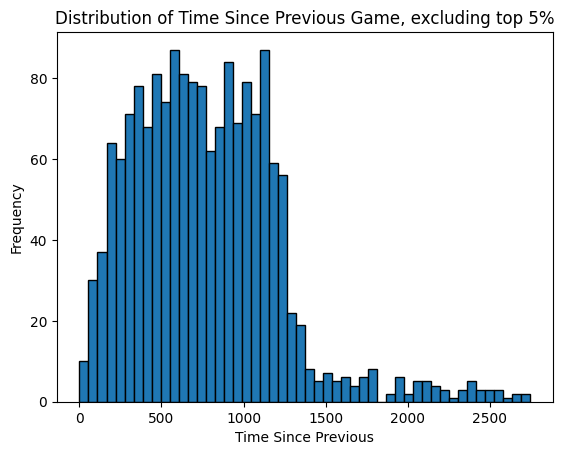

In [14]:
cutoff_value = np.percentile(df['time_since_prev'], 95)

plt.hist(df['time_since_prev'][df['time_since_prev'] <= cutoff_value], bins=50, edgecolor='k')

plt.xlabel('Time Since Previous')
plt.ylabel('Frequency')
plt.title('Distribution of Time Since Previous Game, excluding top 5%')
plt.show()

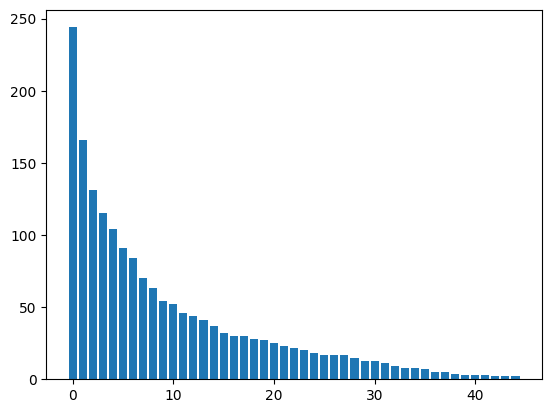

In [10]:
num_reque_counts = df.groupby('num_reque')['unix'].count().to_dict()

plt.bar(num_reque_counts.keys(), num_reque_counts.values())
plt.show()

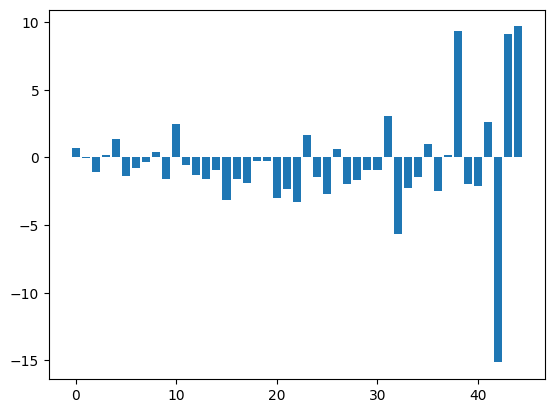

In [11]:
accuracy_by_reque = df.dropna().groupby('num_reque')['acc_diff'].mean().to_dict()

plt.bar(accuracy_by_reque.keys(), accuracy_by_reque.values())
plt.show()

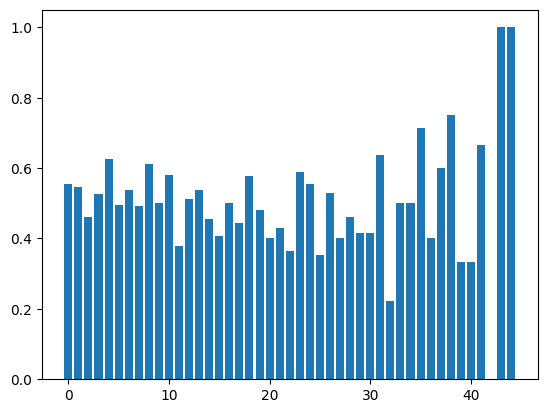

In [12]:
winrate_by_reque = df.dropna().groupby('num_reque')['won'].mean().to_dict()

plt.bar(winrate_by_reque.keys(), winrate_by_reque.values())
plt.show()

c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


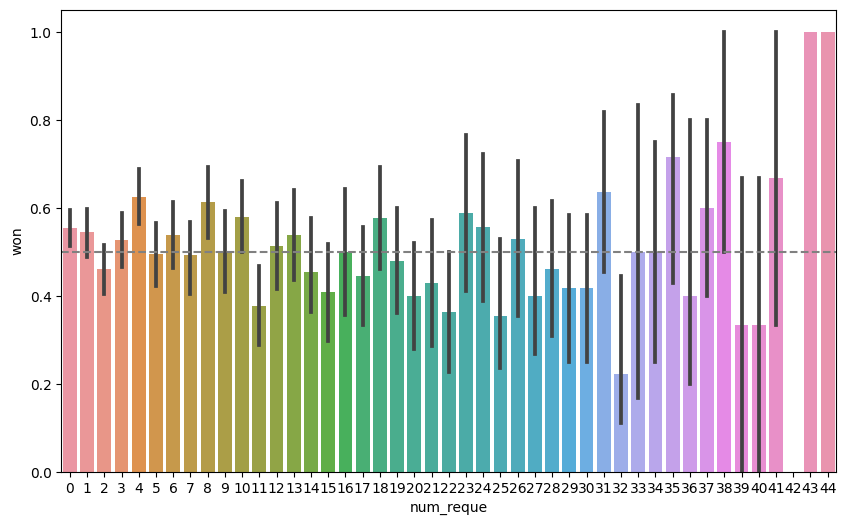

In [22]:
df_cleaned = df.dropna()
df_plot = df_cleaned[['num_reque', 'won']]

plt.figure(figsize=(10, 6))
sns.barplot(x='num_reque', y='won', data=df_plot, errorbar=('ci', 80))
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.show()

c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py

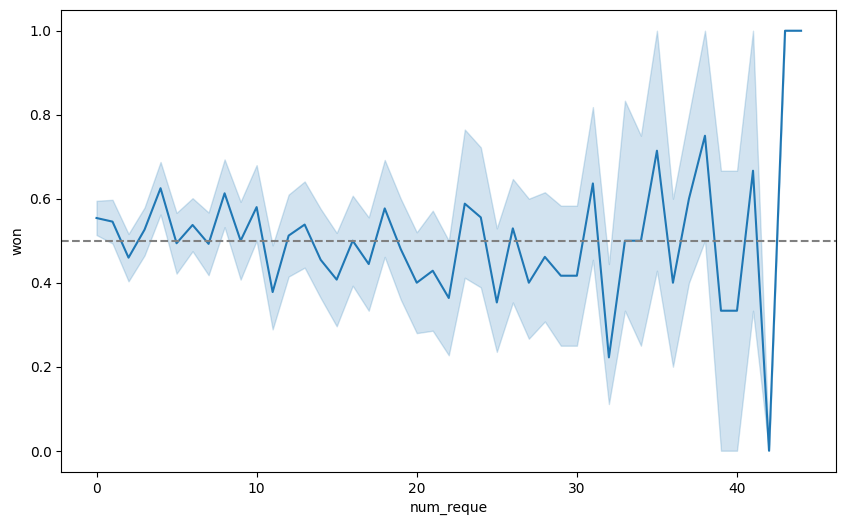

In [21]:
df_cleaned = df.dropna()
df_plot = df_cleaned[['num_reque', 'won']]

plt.figure(figsize=(10, 6))
sns.lineplot(x='num_reque', y='won', data=df_plot, errorbar=('ci', 80))
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.show()

C:\Users\Adam Cunningham\AppData\Local\Temp\ipykernel_1560\1141875473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['time_since_prev_quantile'] = pd.qcut(df_plot['time_since_prev'], 10, labels=False)
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Adam Cunningham\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

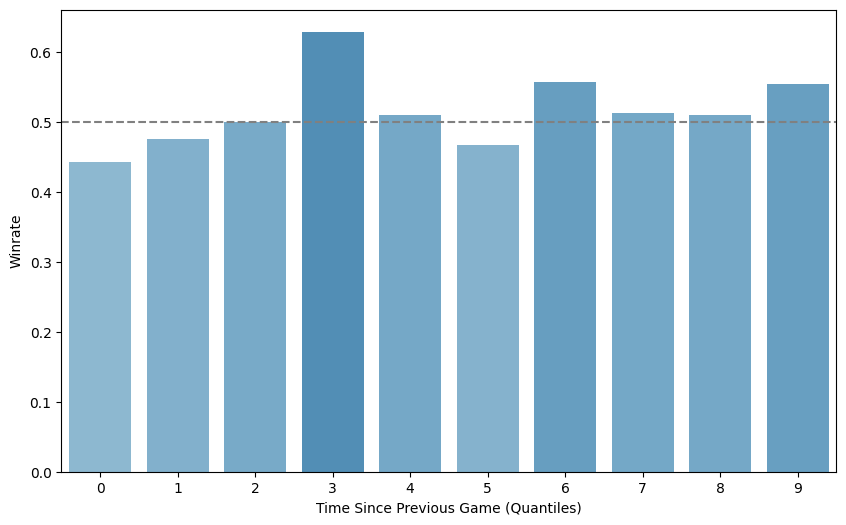

In [45]:
df_plot = df_cleaned[['time_since_prev', 'won']]
df_plot['time_since_prev_quantile'] = pd.qcut(df_plot['time_since_prev'], 10, labels=False)

quantile_winrate = df_plot.groupby('time_since_prev_quantile')['won'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='time_since_prev_quantile', y='won', data=quantile_winrate, palette=plt.cm.Blues(quantile_winrate['won']))
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.xlabel('Time Since Previous Game (Quantiles)')
plt.ylabel('Winrate')
plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df_cleaned[['num_reque']]
y = df_cleaned['won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.21      0.31       242
         1.0       0.53      0.83      0.65       255

    accuracy                           0.53       497
   macro avg       0.54      0.52      0.48       497
weighted avg       0.54      0.53      0.48       497



In [63]:
from sklearn.tree import DecisionTreeClassifier

df_cleaned = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_cleaned[['time_since_prev', 'num_reque']], df_cleaned['won'], test_size=0.3, random_state=42)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)

print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

         0.0       0.50      0.54      0.52       242
         1.0       0.53      0.50      0.51       255

    accuracy                           0.52       497
   macro avg       0.52      0.52      0.52       497
weighted avg       0.52      0.52      0.52       497

